# Load Data

In [135]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

## Data Extraction

In [136]:
import yfinance as yf

tsla = yf.Ticker("TSLA")

# get stock info
tsla.info

# get historical market data as df
hist = tsla.history(period="max")

# Save df as CSV
hist.to_csv('../TSLA.CSV')

In [137]:
# Read data in to dataframes
tsla = pd.read_csv('../TSLA.csv')

# Change date column to datetime type
tsla['Date'] = pd.to_datetime(tsla['Date'])

In [138]:
tsla.dropna(inplace=True)

### TSLA Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just shy of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

I will be choosing an arbitrary date to separate the training, validation, and test data.

In [139]:
series = tsla['Close']

# Create train data set
train_split_date = '2015-12-31'
train_split_index = np.where(tsla.Date == train_split_date)[0][0]
x_train = tsla.loc[tsla['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2018-01-02'
test_split_index = np.where(tsla.Date == test_split_date)[0][0]
x_test = tsla.loc[tsla['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = tsla.loc[(tsla['Date'] < test_split_date) & (tsla['Date'] > train_split_date)]['Close']

1387 1388 1890 1891 2614


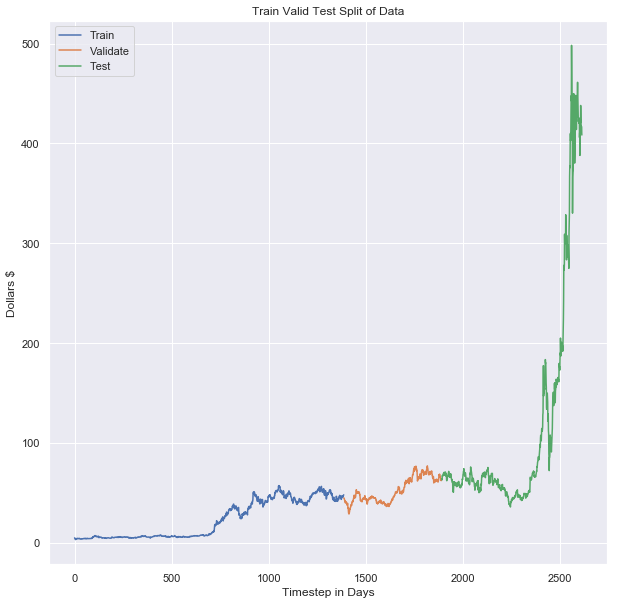

In [140]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [141]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting
A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.

Text(0.5,1,'Price History of TSLA Jan-1993 to Sept-2020')

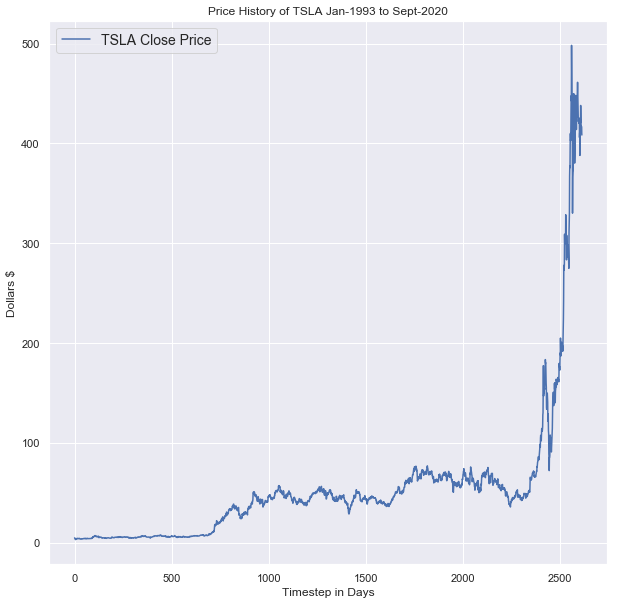

In [142]:
# Plot chart with all details untouched
plot_series(time=tsla.index,series=tsla['Close'], label = 'TSLA Close Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Price History of TSLA Jan-1993 to Sept-2020')

In [143]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5,1,'Naive Forecast vs Actual')

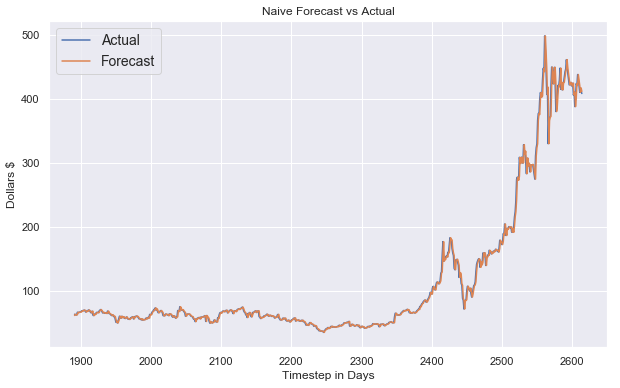

In [144]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Naive Forecast vs Actual')

### Calculate Error in Naive Model

In [145]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 3.8577487}

In [146]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[62.27 64.11 63.45]
[64.11 63.45 62.92]
****************************************************************************************************
[1.84 0.66 0.53]


# Monthly Moving Average Model (20 Day MA)
Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5,1,'SMA20 vs Actual')

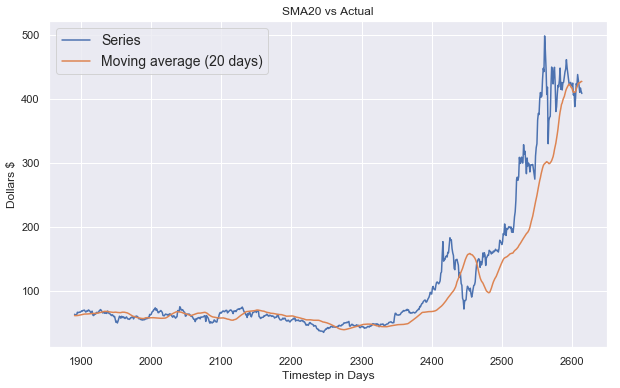

In [147]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = tsla['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:tsla.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')

In [148]:
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 3.8577487, 'SMA 20': 22.215728024477446}

# Weekly Moving Average (5 day MA)
I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5,1,'SMA5 Forecast vs Actual')

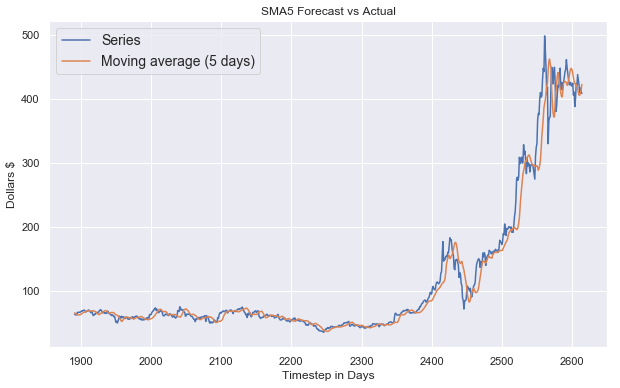

In [149]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = tsla['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:tsla.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [150]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 3.8577487, 'SMA 20': 22.215728024477446, 'SMA 5': 10.082237675703698}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

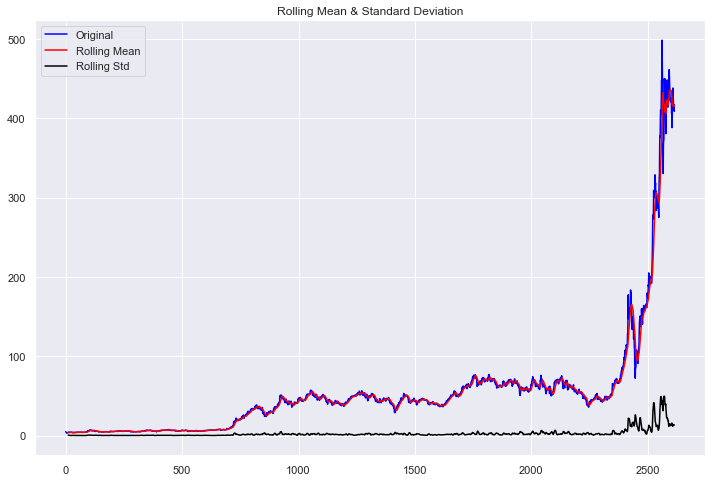

Results of Dickey-Fuller Test:
p-value = 1.0000. The series is likely non-stationary.
Test Statistic                    3.528045
p-value                           1.000000
#Lags Used                       20.000000
Number of Observations Used    2594.000000
Critical Value (1%)              -3.432873
Critical Value (5%)              -2.862655
Critical Value (10%)             -2.567363
dtype: float64


In [151]:
test_stationarity(series)

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [152]:
# Get the difference of each Adj Close point
tsla_close_diff_1 = series.diff()
tsla_close_diff_1.dropna(inplace=True)

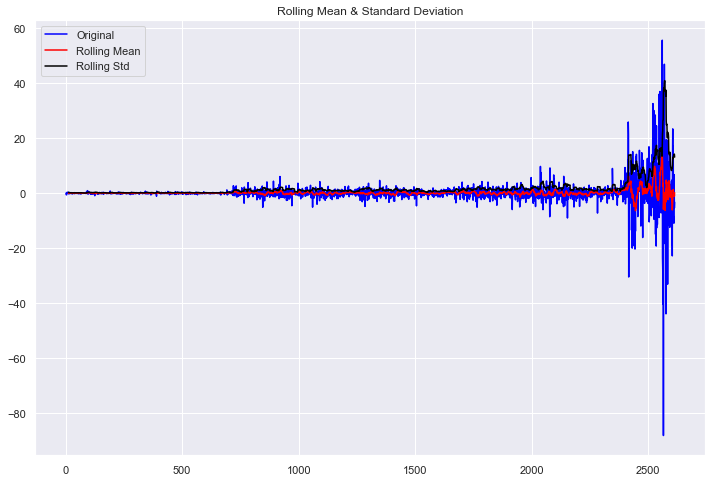

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.136273e+01
p-value                        9.386559e-21
#Lags Used                     1.900000e+01
Number of Observations Used    2.594000e+03
Critical Value (1%)           -3.432873e+00
Critical Value (5%)           -2.862655e+00
Critical Value (10%)          -2.567363e+00
dtype: float64


In [153]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(tsla_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

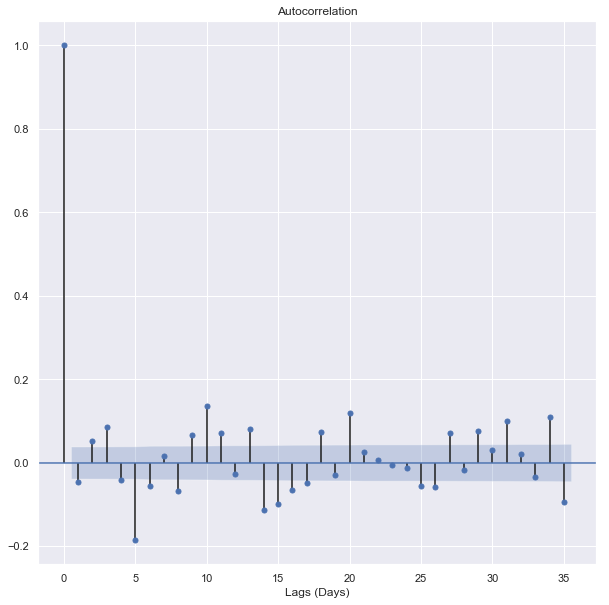

In [154]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(tsla_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

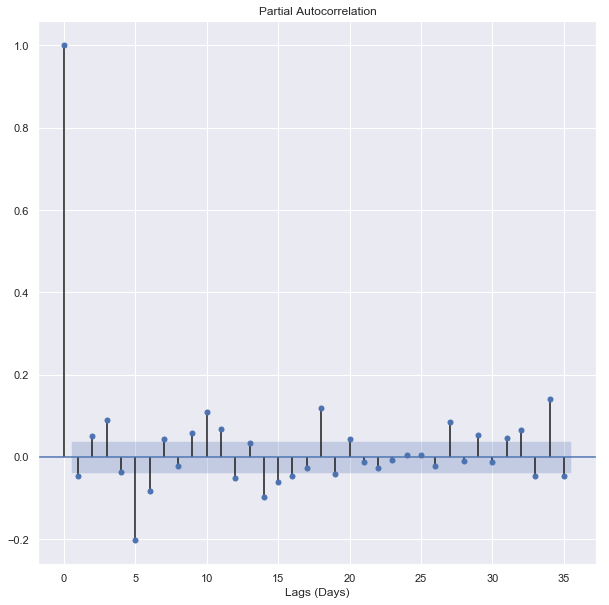

In [155]:
plot_pacf(tsla_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

- These plots look almost identical, but they’re not. Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, and the 2nd lag is positive, we will use the 1st lag as a moving average point.
<br/><br/>
- For the PACF plot, since there is a substantial dropoff at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.
<br/><br/>
- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term. We have determined the best model for our data is of order (1,1,1). Once again, feel free to change these numbers and print out the summary of the models to see which variation has the lowest AIC. The training time is relatively quick.

### Testing different arima models

In [156]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
tsla_arima = ARIMA(x_train, order=(1,1,1))
tsla_arima_fit = tsla_arima.fit(disp=0)
print(tsla_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1387
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1739.382
Method:                       css-mle   S.D. of innovations              0.848
Date:                Sun, 15 Nov 2020   AIC                           3486.764
Time:                        04:51:40   BIC                           3507.703
Sample:                             1   HQIC                          3494.595
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0312      0.023      1.358      0.175      -0.014       0.076
ar.L1.D.Close    -0.7196      0.281     -2.562      0.010      -1.270      -0.169
ma.L1.D.Close     0.7339      0.274     

NormaltestResult(statistic=240.42869873414256, pvalue=6.188300922964277e-53)
This distribution is not a normal distribution


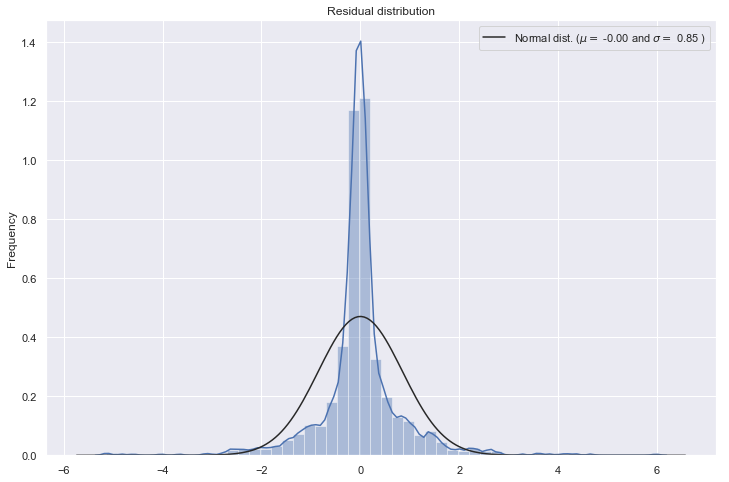

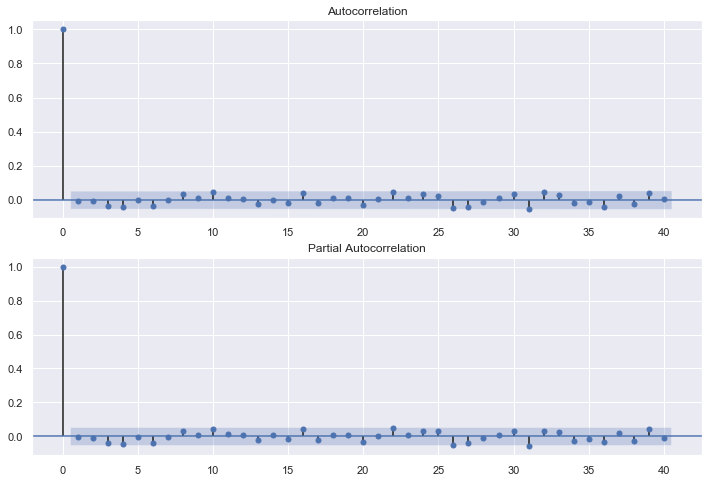

In [157]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = tsla_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (1,1,1) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

In [158]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(4,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is [ 68.43035807  61.26255105  61.15442801  61.13103129  61.13028887
  62.17368984  61.16093159  61.21160664  61.31682647  61.2460897
  61.26605253  61.58872481  61.43691617  61.73677704  61.85070844
  61.90065292  61.40961494  61.16834721  61.2830829   61.54753239
  61.35932307  61.95171608  61.67158133  61.35622915  61.13214637
  61.13021421  61.32454606  61.58044173  61.74936657  61.43772806
  61.20866533  61.27537861  61.20150079  61.25220265  61.21384248
  61.15375667  61.64462491  61.89424971  62.31199091  61.84587472
  61.39532875  61.13994461  61.13027655  61.13867002  61.17610043
  61.1310376   61.13738235  61.15642634  61.50928736  61.35371954
  61.15391925  61.15658037  61.22728512  61.63074375  61.7516082
  61.35269289  61.70666306  62.1313487   61.85619915  64.47177835
  67.74571763  66.24966094  68.56679466  65.82413937  62.89443567
  61.31582742  61.6619844   62.18009582  61.42215271  61.85782966
  62.53113282  61.94073371  62.68646391  63.1801

In [159]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[array([48.41311508]),
 array([68.14553196]),
 array([67.10232862]),
 array([66.50442741]),
 array([66.17515894])]

In [160]:
#save model
model_fit.save('arima_111.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')

In [161]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 3.8577487,
 'SMA 20': 22.215728024477446,
 'SMA 5': 10.082237675703698,
 'ARIMA': 4.55630548090095}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

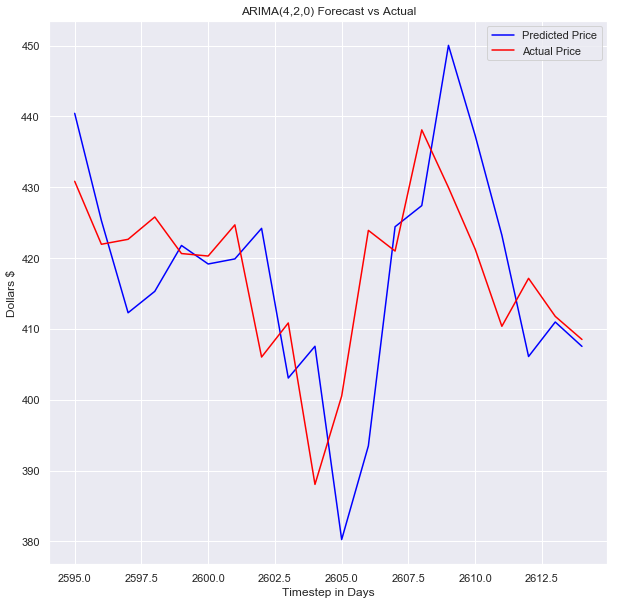

<Figure size 720x432 with 0 Axes>

In [170]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-20:], model_predictions[-20:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-20:], x_test[-20:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(4,2,0) Forecast vs Actual')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

#### Show Error in model vs actual

In [163]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

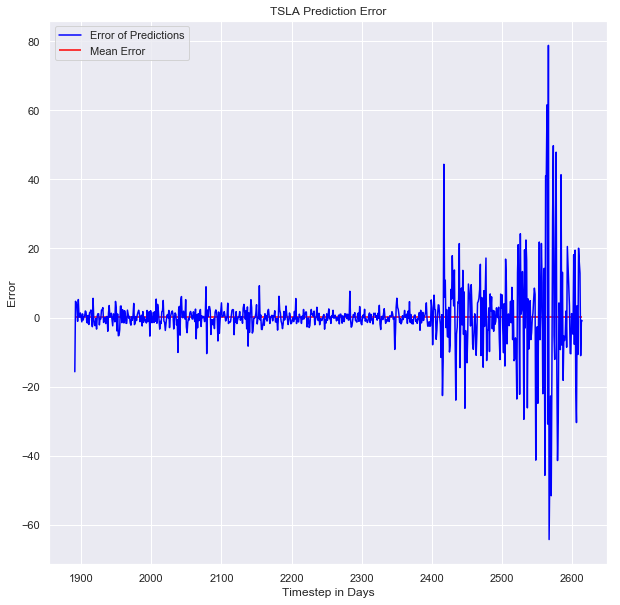

<Figure size 720x432 with 0 Axes>

In [164]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('TSLA Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Summary of ALL Model Results

### Bringing in values from other deep learning models

In [165]:
model_mae_scores['linear_model'] = 3.8284044
model_mae_scores['dense_model'] = 5.4198823
model_mae_scores['rnn_seqtoseq'] = 6.204379
model_mae_scores['rnn_seqtovec'] = 23.704935
model_mae_scores['lstm_30day'] = 1.1875452
model_mae_scores['cnn_preprocessing_rnn_20'] = 15.492888
model_mae_scores['full_cnn'] = 3.5446732

In [166]:
# Store MAE scores
%store model_mae_scores

Stored 'model_mae_scores' (dict)


In [167]:
%store -r model_mae_scores
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 3.8577487,
 'SMA 20': 22.215728024477446,
 'SMA 5': 10.082237675703698,
 'ARIMA': 4.55630548090095,
 'linear_model': 3.8284044,
 'dense_model': 5.4198823,
 'rnn_seqtoseq': 6.204379,
 'rnn_seqtovec': 23.704935,
 'lstm_30day': 1.1875452,
 'cnn_preprocessing_rnn_20': 15.492888,
 'full_cnn': 3.5446732}

In [168]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

Text(0.5,1,'Mean Average Error of All Models Tested')

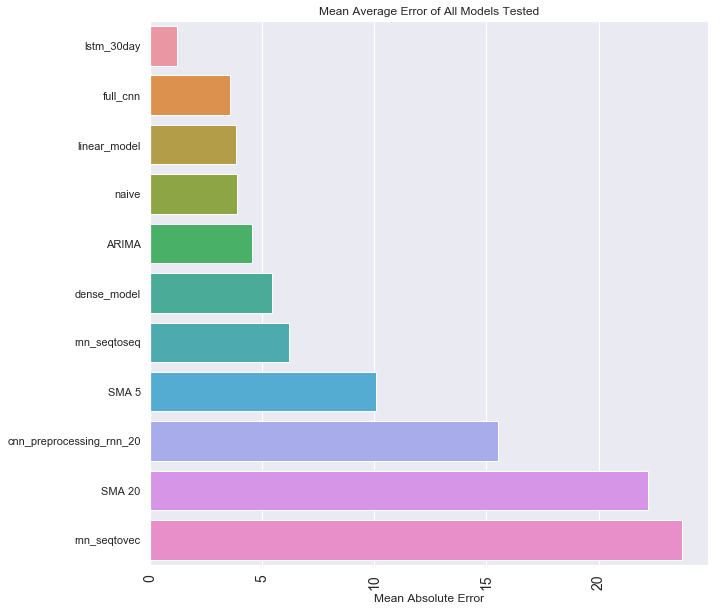

In [169]:
# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')
